# Project 1 MLP --- test part

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from collections import defaultdict
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset

In [2]:
# Define hyperparameters
batch_size = 100
learning_rate = 0.001  # Adjusted as per the optimizer initialization

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations with data augmentation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Downloading the test datasets
test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

criterion = nn.CrossEntropyLoss()

# Initializing lists to monitor test loss and accuracy per class
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# Creating dataloader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

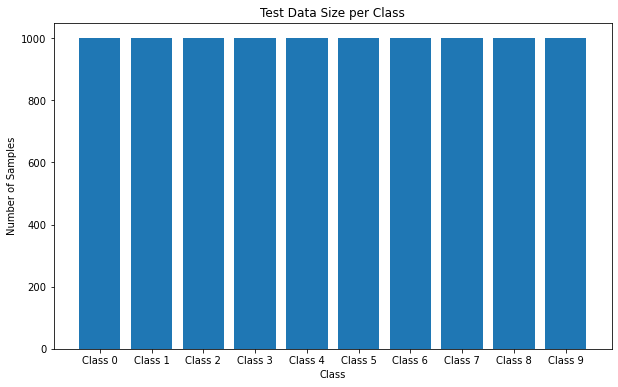

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already loaded the test dataset
test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

# Get the labels from the test dataset
test_labels = np.array(test_dataset.targets)

# Calculate the number of samples per class
unique_labels, label_counts = np.unique(test_labels, return_counts=True)

# Create a bar chart to visualize the test data size per class
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts)
plt.xticks(unique_labels, [f'Class {label}' for label in unique_labels])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Test Data Size per Class')
plt.show()

# Visualization of Test Dataset

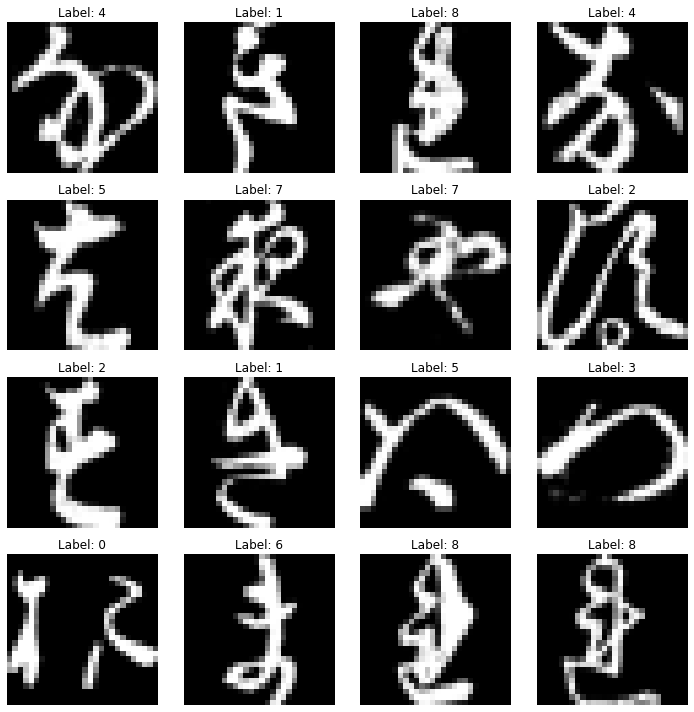

In [4]:
import matplotlib.pyplot as plt
import numpy as np


test_dataset = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)

# We fetch a batch of test images and labels
dataiter = iter(test_loader)
images, labels = next(dataiter)

# To display a grid of images
def show_images(images, labels, num_images=16):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(num_images):
        ax = axes[i // 4, i % 4]
        ax.imshow(images[i].squeeze().numpy(), cmap='gray')
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display the batch of test images
show_images(images, labels)


# MLP Model

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.flatten = nn.Flatten()

        # First hidden layer: 784 -> 512
        self.fc1 = nn.Linear(784, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')

        # Second hidden layer: 512 -> 256
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')

        # Output layer: 256 -> 10
        self.fc3 = nn.Linear(256, 10)
        init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')

    def forward(self, x):
        x = self.flatten(x)
        
        # First hidden layer
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        # Second hidden layer
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        # Output layer
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)


In [6]:
# Loading the trained model weights
model = MLP()
model.load_state_dict(torch.load('model.pth'))  # Load the trained model weights

<All keys matched successfully>

# Test evaluation

In [7]:
# Model is set to evaluation mode
model.eval()

# Initializing lists for storing true labels and predicted labels
true_labels = []
predicted_labels = []
test_probs = []

# Evaluating the model on the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
# Converting the true labels to binary format
true_labels_binary = np.zeros((len(true_labels), 10))
true_labels_binary[np.arange(len(true_labels)), true_labels] = 1

# Calculate accuracy
correct = sum(true == predicted for true, predicted in zip(true_labels, predicted_labels))
total = len(true_labels)
accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 92.99%


# Confusion matrix

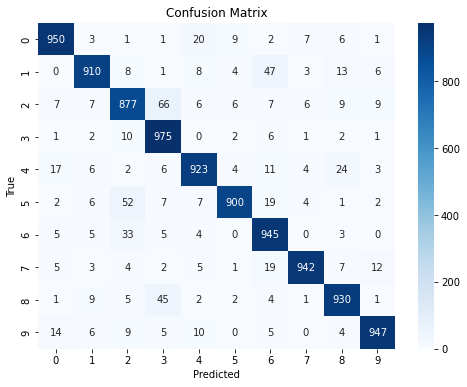

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate and display the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Classification Report

In [9]:
from sklearn.metrics import classification_report

# Generate and display the classification report
classification_rep = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1000
           1       0.95      0.91      0.93      1000
           2       0.88      0.88      0.88      1000
           3       0.88      0.97      0.92      1000
           4       0.94      0.92      0.93      1000
           5       0.97      0.90      0.93      1000
           6       0.89      0.94      0.92      1000
           7       0.97      0.94      0.96      1000
           8       0.93      0.93      0.93      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



# Precision Recall Curve

In [10]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score

model.eval()

# These lists will store the results
test_probs = []
true_labels = []

# No gradients needed as we're only doing forward passes in evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # if you're using a GPU

        # Forward pass and softmax
        outputs = model(images)
        softmax_outputs = F.softmax(outputs, dim=1)

        # Store results - make sure you move data to CPU if you're using a GPU
        test_probs.extend(softmax_outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Converting the collected probabilities and labels to NumPy arrays
test_probs_np = np.array(test_probs)
true_labels_np = np.array(true_labels)
        
# Checking for any inconsistencies in length
if test_probs_np.shape[0] != true_labels_np.shape[0]:
    raise ValueError("Mismatch between the number of predictions and true labels.")
        
# Binarize the labels
num_classes = 10
test_true_labels_bin = label_binarize(true_labels_np, classes=range(num_classes))

# Computing precision and recall for each class
precision = {}
recall = {}
average_precision = {}
for i in range(10):
    precision[i], recall[i], _ = precision_recall_curve(test_true_labels_bin[:, i], test_probs_np[:, i])
    average_precision[i] = average_precision_score(test_true_labels_bin[:, i], test_probs_np[:, i])

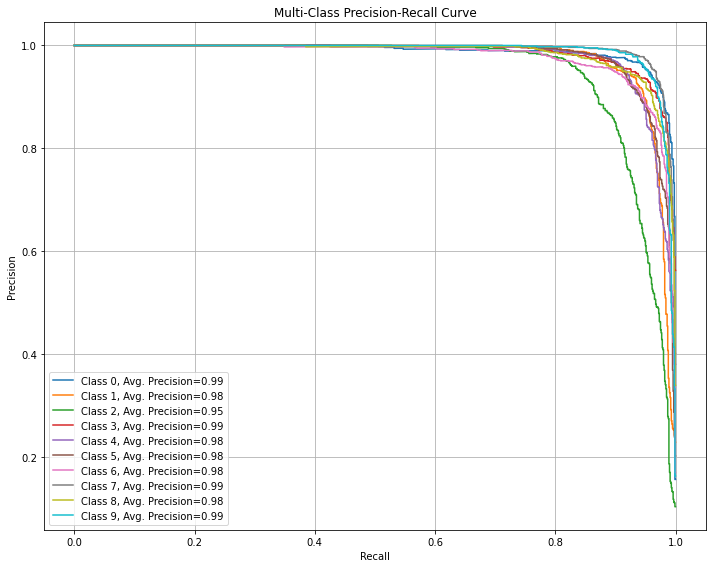

In [11]:
plt.figure(figsize=(10, 8))

# For each class
for i in range(10):
    plt.plot(recall[i], precision[i], label=f"Class {i}, Avg. Precision={average_precision[i]:.2f}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-Class Precision-Recall Curve')
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()


# Histogram of weights

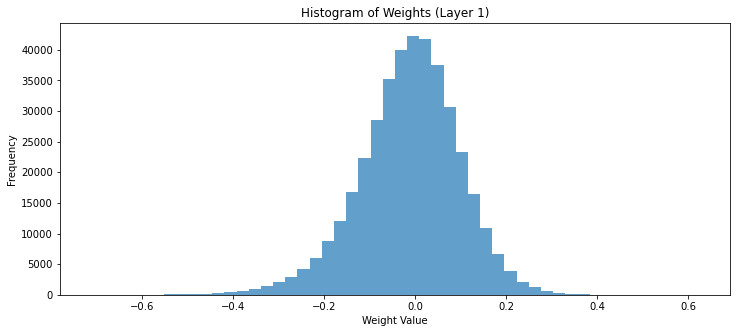

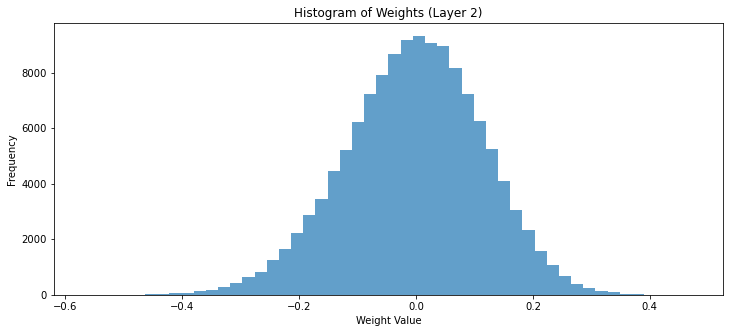

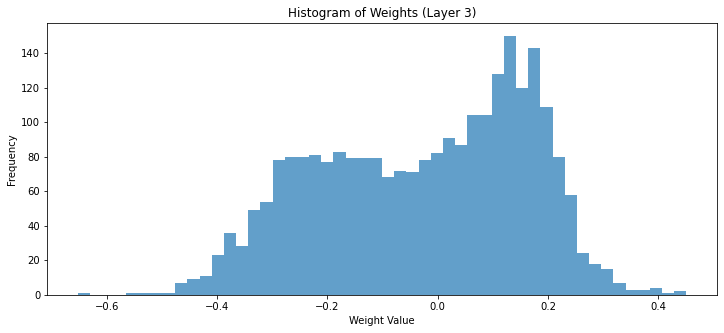

In [12]:
import matplotlib.pyplot as plt

def plot_weight_histogram(model):
    # Counter for layer number
    layer_num = 1

    # Loop through each layer in the model
    for layer in model.children():
        # Checking if the layer is a linear layer
        if isinstance(layer, torch.nn.Linear):
            # Extract weights
            weights = layer.weight.detach().cpu().numpy()

            # Create histogram
            plt.figure(figsize=(12, 5))
            plt.hist(weights.flatten(), bins=50, alpha=0.7)
            plt.title(f'Histogram of Weights (Layer {layer_num})')
            plt.xlabel('Weight Value')
            plt.ylabel('Frequency')
            plt.show()

            layer_num += 1

plot_weight_histogram(model)


# Misclassified Images Visualisation

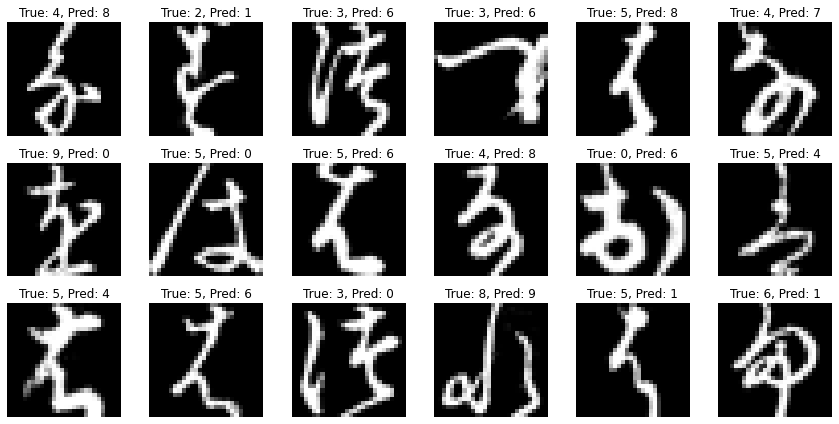

In [13]:
# We collect both images and their true labels
all_test_images = []
all_true_labels = [] 
for batch_images, batch_labels in test_loader:
    all_test_images.extend(batch_images)
    all_true_labels.extend(batch_labels.numpy())

# Now, we find misclassified indices
misclassified_indices = [i for i, (true, pred) in enumerate(zip(all_true_labels, predicted_labels)) if true != pred]

# Based on the misclassified indices, we get the misclassified images, true labels, and predicted labels
misclassified_images = [all_test_images[i] for i in misclassified_indices]
misclassified_true_labels = [all_true_labels[i] for i in misclassified_indices]
misclassified_pred_labels = [predicted_labels[i] for i in misclassified_indices]


# Displaying a selection of misclassified images
num_images_to_display = min(18, len(misclassified_images))
fig, axes = plt.subplots(3, 6, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    if i >= num_images_to_display:
        break
    
    # Display image
    image = misclassified_images[i].cpu().squeeze().numpy()  # Convert to numpy array
    image = image * 0.5 + 0.5  # Un-normalize
    ax.imshow(image, cmap='gray')
    
    # Display true and predicted labels
    true_label = misclassified_true_labels[i]
    pred_label = misclassified_pred_labels[i]
    ax.set_title(f'True: {true_label}, Pred: {pred_label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Visualization of Sample Test results

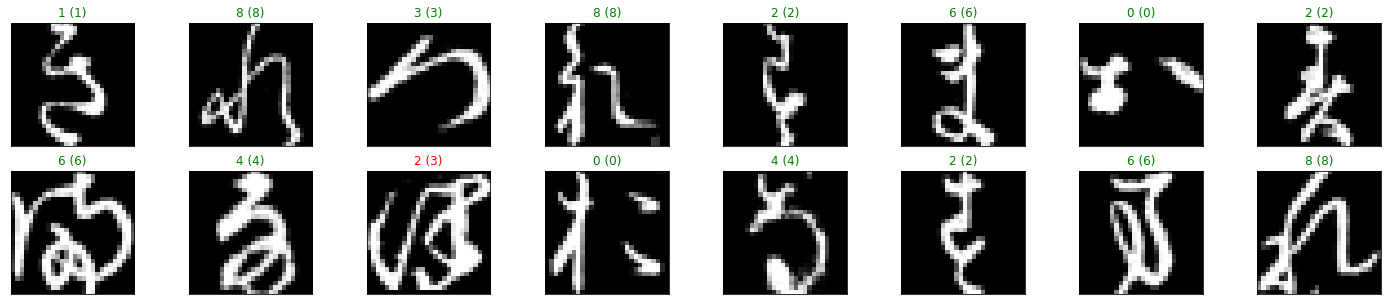

In [14]:
model.eval()

# We get one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)


if not isinstance(images, torch.Tensor) or not isinstance(labels, torch.Tensor):
    raise TypeError("Expected PyTorch Tensor but got different type for images or labels.")

# Move the input batch to the same device as the model
images = images.to(device)
labels = labels.to(device)

# Get sample outputs
output = model(images)
# Convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# We need to move the data back to cpu from gpu before converting to numpy array
images = images.cpu().numpy()
preds = preds.cpu().numpy()
labels = labels.cpu().numpy()

num_images = 16  
assert len(images) >= num_images, f"Batch size is smaller than the desired number of images to display: {num_images}"

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 5))  # adjusting the size of the figure

for idx in range(num_images):
    ax = fig.add_subplot(2, num_images//2, idx+1, xticks=[], yticks=[])
    
    ax.imshow(np.squeeze(images[idx]), cmap='gray') 
    
    correct = preds[idx] == labels[idx]
    ax.set_title(f'{preds[idx]} ({labels[idx]})', color=('green' if correct else 'red'))
plt.show()

# Test Loss and Accuracy

In [15]:
# Iterate over the test data
for data, target in test_loader:
    # Move tensors to the configured device
    data, target = data.to(device), target.to(device)
    
    # Forward pass
    output = model(data)

    # Calculate the loss
    loss = criterion(output, target)
    
    # Update test loss
    test_loss += loss.item() * data.size(0)
    
    # Convert output probabilities to predicted class (0-9)
    _, pred = torch.max(output, 1)
    
    # Compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy()) if device.type == 'cuda' else np.squeeze(correct_tensor.numpy())
    
    # Calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Calculate average test loss
test_loss = test_loss / len(test_loader.dataset)
print(f'Test Loss: {test_loss:.6f}\n')

for i in range(10):
    if class_total[i] > 0:
        print(f'Test Accuracy of {i:5}: {100 * class_correct[i] / class_total[i]:.2f}% ({int(np.sum(class_correct[i]))}/{int(np.sum(class_total[i]))})')
    else:
        print(f'Test Accuracy of {i:5}: N/A (no training examples)')

print(f'\nTest Accuracy (Overall): {100. * np.sum(class_correct) / np.sum(class_total):.2f}% ({int(np.sum(class_correct))}/{int(np.sum(class_total))})')

Test Loss: 0.236037

Test Accuracy of     0: 95.00% (950/1000)
Test Accuracy of     1: 91.00% (910/1000)
Test Accuracy of     2: 87.70% (877/1000)
Test Accuracy of     3: 97.50% (975/1000)
Test Accuracy of     4: 92.30% (923/1000)
Test Accuracy of     5: 90.00% (900/1000)
Test Accuracy of     6: 94.50% (945/1000)
Test Accuracy of     7: 94.20% (942/1000)
Test Accuracy of     8: 93.00% (930/1000)
Test Accuracy of     9: 94.70% (947/1000)

Test Accuracy (Overall): 92.99% (9299/10000)


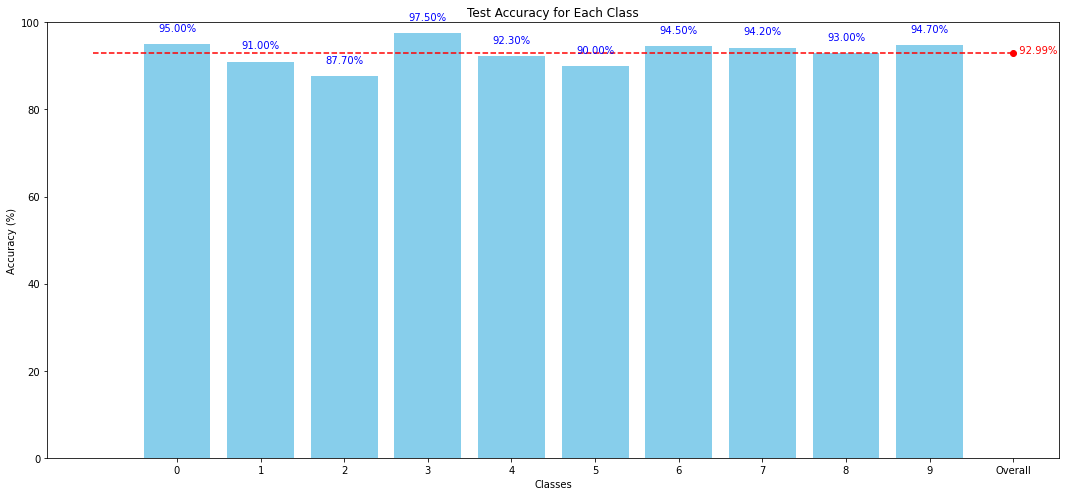

In [16]:
import matplotlib.pyplot as plt
import numpy as np

class_accuracy = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(10)]
class_names = [str(i) for i in range(10)]  # e.g., '0', '1', '2', ..., representing class labels

# Overall accuracy
overall_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)

# Create bar plot
plt.figure(figsize=(15, 7))
plt.bar(class_names, class_accuracy, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy for Each Class')
plt.ylim([0, 100])  # Making the y-axis start from 0 to 100 for percentage

# Adding the overall accuracy as a separate point or line
plt.scatter(['Overall'], [overall_accuracy], color='red') 
plt.plot([-1, 10], [overall_accuracy, overall_accuracy], 'r--')  

# Displaying the actual percentages
for i, v in enumerate(class_accuracy):
    plt.text(i, v + 3, f"{v:.2f}%", color='blue', ha='center')  # Shift the text slightly above the bars

plt.text(10, overall_accuracy, f"  {overall_accuracy:.2f}%", color='red')  # adding the overall accuracy text

# Show the plot
plt.tight_layout()
plt.show()